In [1]:
import os,sys,string, time
import ROOT
from math import *
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Loading in the "results" dataframe after full selection

In [2]:
Run = "run1" #so far either "run1" or "run3"

HNL_masses = Constants.HNL_mass_samples

loc_pkl = f'pkl_files/{Run}/current_files/Results/'

overlay_results = pd.read_pickle(loc_pkl+"overlay_results.pkl") #This will contain all of the BDT output scores and rse_id

# Reading in the overlay .root file with reweight branches

In [3]:
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run3

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


# Keeping only the events which pass selection in the weight dataframe

In [4]:
def make_unique_ev_id(df): #df must have 'run', 'sub' and 'evt' branches
    if pd.Series(['run', 'sub', 'evt']).isin(df.columns).all():
        rse_list = []
        for entry in df.index: #Looping over all events in the dataframe
            rse = str(df['run'][entry]) + "_" + str(df['sub'][entry]) + "_" + str(df['evt'][entry])
            rse_list.append(rse)
        df['rse_id'] = rse_list #Writing a new branch with the unique event id
        return df.copy()
    else:
        print("Dataframe needs \"run\", \"sub\" and \"evt\" columns.")
        return 0
    
def check_duplicate_events(df):
    rse_list = df['rse_id'].to_list()

    seen = set()
    dupes = []

    for x in rse_list:
        if x in seen:
            dupes.append(x)
        else:
            seen.add(x)
    print("Number of duplicates is " + str(len(dupes)))
    print("Number of unique events is " + str(len(seen)))

overlay_results_rse = make_unique_ev_id(overlay_results)
df_overlay_weights_rse = make_unique_ev_id(df_overlay_weights)

#Deleting any duplicates of events, should be able to avoid if correctly filtered for one event per row
overlay_results_rse.drop_duplicates(subset=['rse_id'], keep='first', inplace=True)

print("Number of events in weights file is " + str(len(df_overlay_weights_rse)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in weights file is 914729
Number of events in results file is 47855


In [5]:
#Keeping only those events in the final selection
filtered_weights = df_overlay_weights_rse.loc[(df_overlay_weights_rse['rse_id'].isin(overlay_results_rse['rse_id']))]

print("Number of events in the filtered weights file is " + str(len(filtered_weights)))
print("Number of events in results file is " + str(len(overlay_results_rse)))

Number of events in the filtered weights file is 47855
Number of events in results file is 47855


## Merging into one dataframe with results and weights

In [6]:
BDT_score_list = []

for HNL_mass in HNL_masses:
    BDT_score_list.append(f'BDT_output_{HNL_mass}MeV')

just_score_df = overlay_results_rse[BDT_score_list + ['rse_id','weight']].copy()

final_merged = pd.merge(filtered_weights,just_score_df, how='outer', on=['rse_id']) #This will have the reweighting branches AND BDT score branches


# Plotting the BDT score with all different multisims

In [7]:
def All_reweight_err(df, var_name, n_bins, x_range, Norm):
    results_dict = {}
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=n_bins, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=n_bins)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [8]:
HNL_mass = 50
results_dict = All_reweight_err(final_merged, f'BDT_output_{HNL_mass}MeV', 20, [0,1.0], Norm)

In [9]:
def Plot_multisim(results_dict, HNL_mass, savefig=False):
    for Multisim in results_dict:
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        bins = results_dict[Multisim][3]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        bins=np.linspace(0,1.0,21)

        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        plt.ylim(0,30)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f"BDT score ({HNL_mass} MeV HNL) ",fontsize=25)
        if savefig == True:
            plt.savefig("plots/Sys_uncertainty/Overlay/" + Run + "_" + str(HNL_mass) + "_MeV_" + Multisim + ".png")

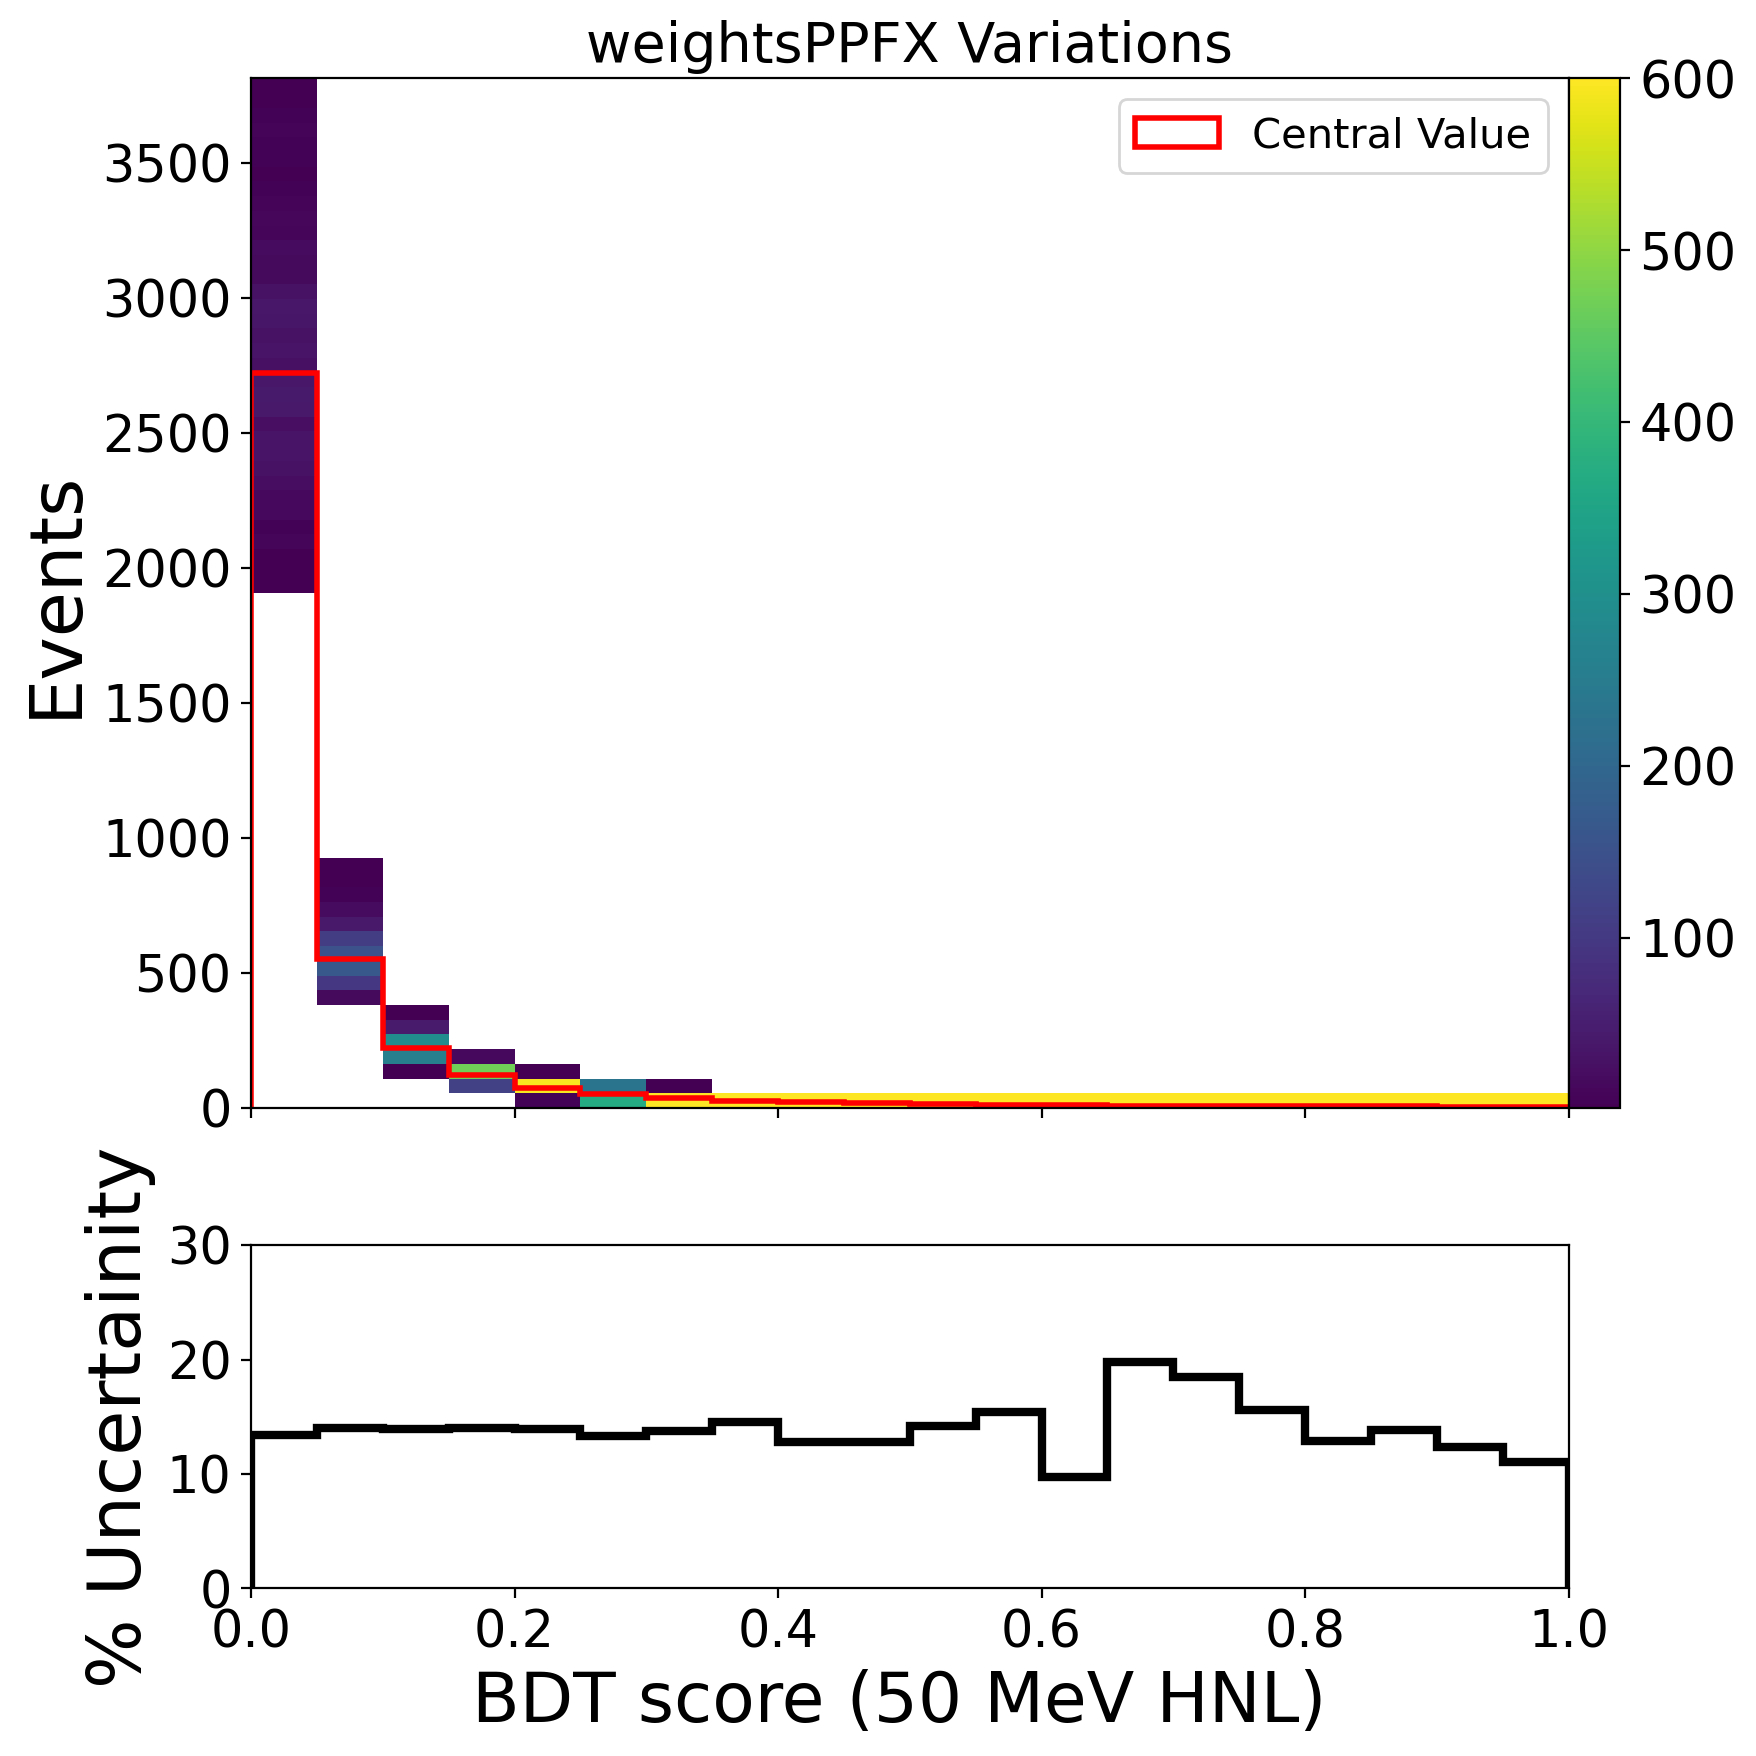

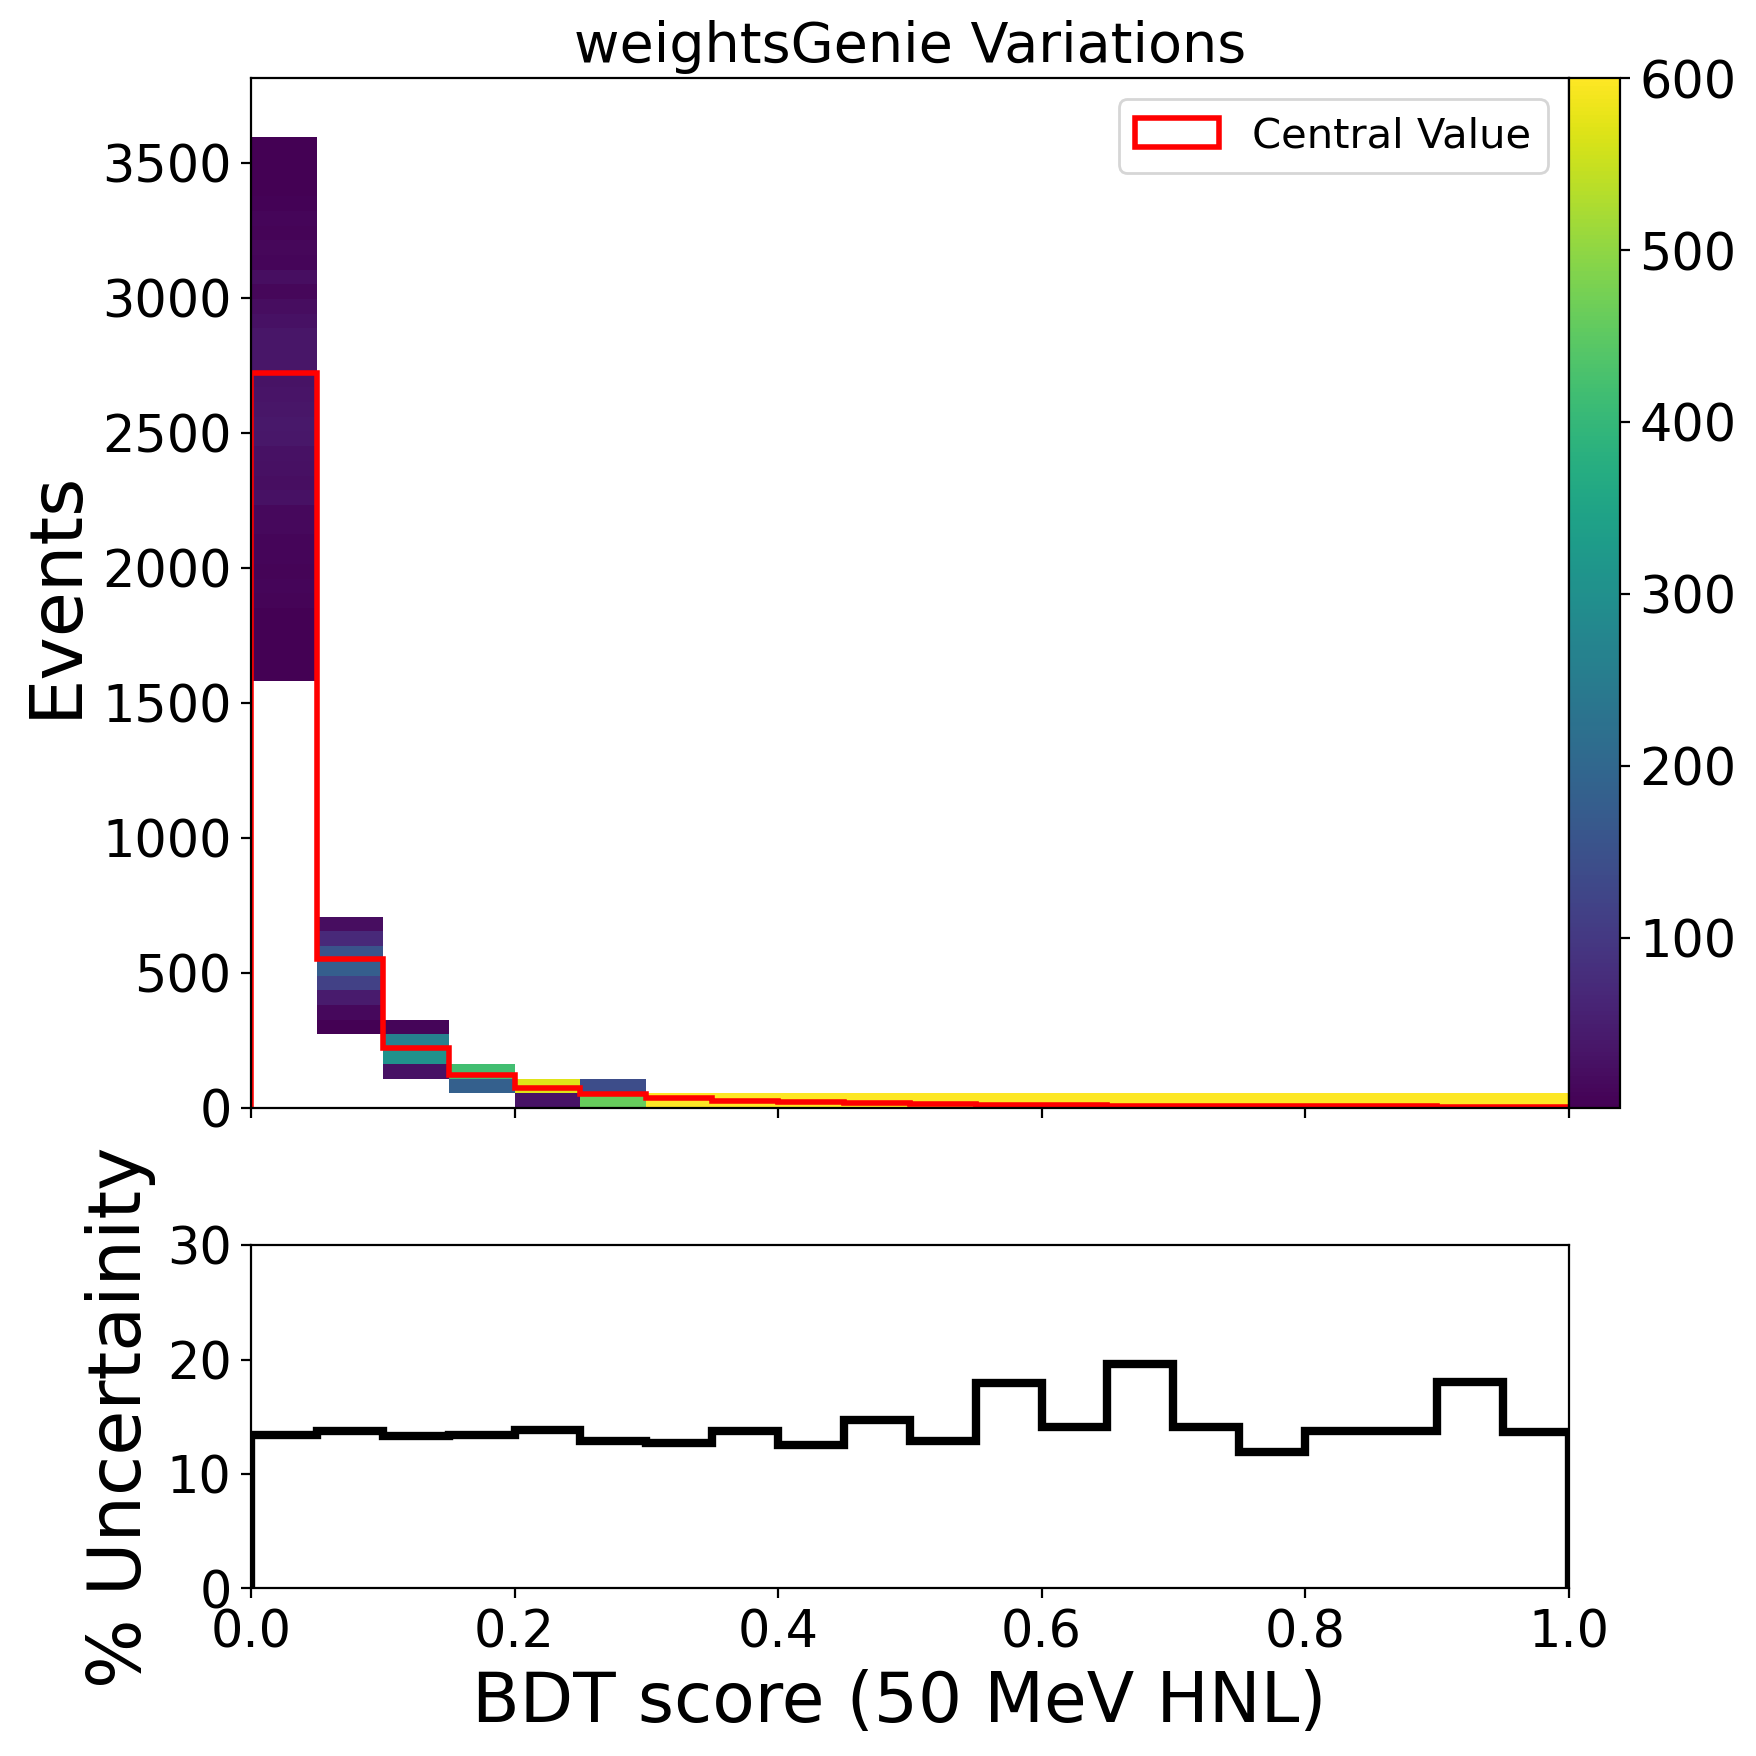

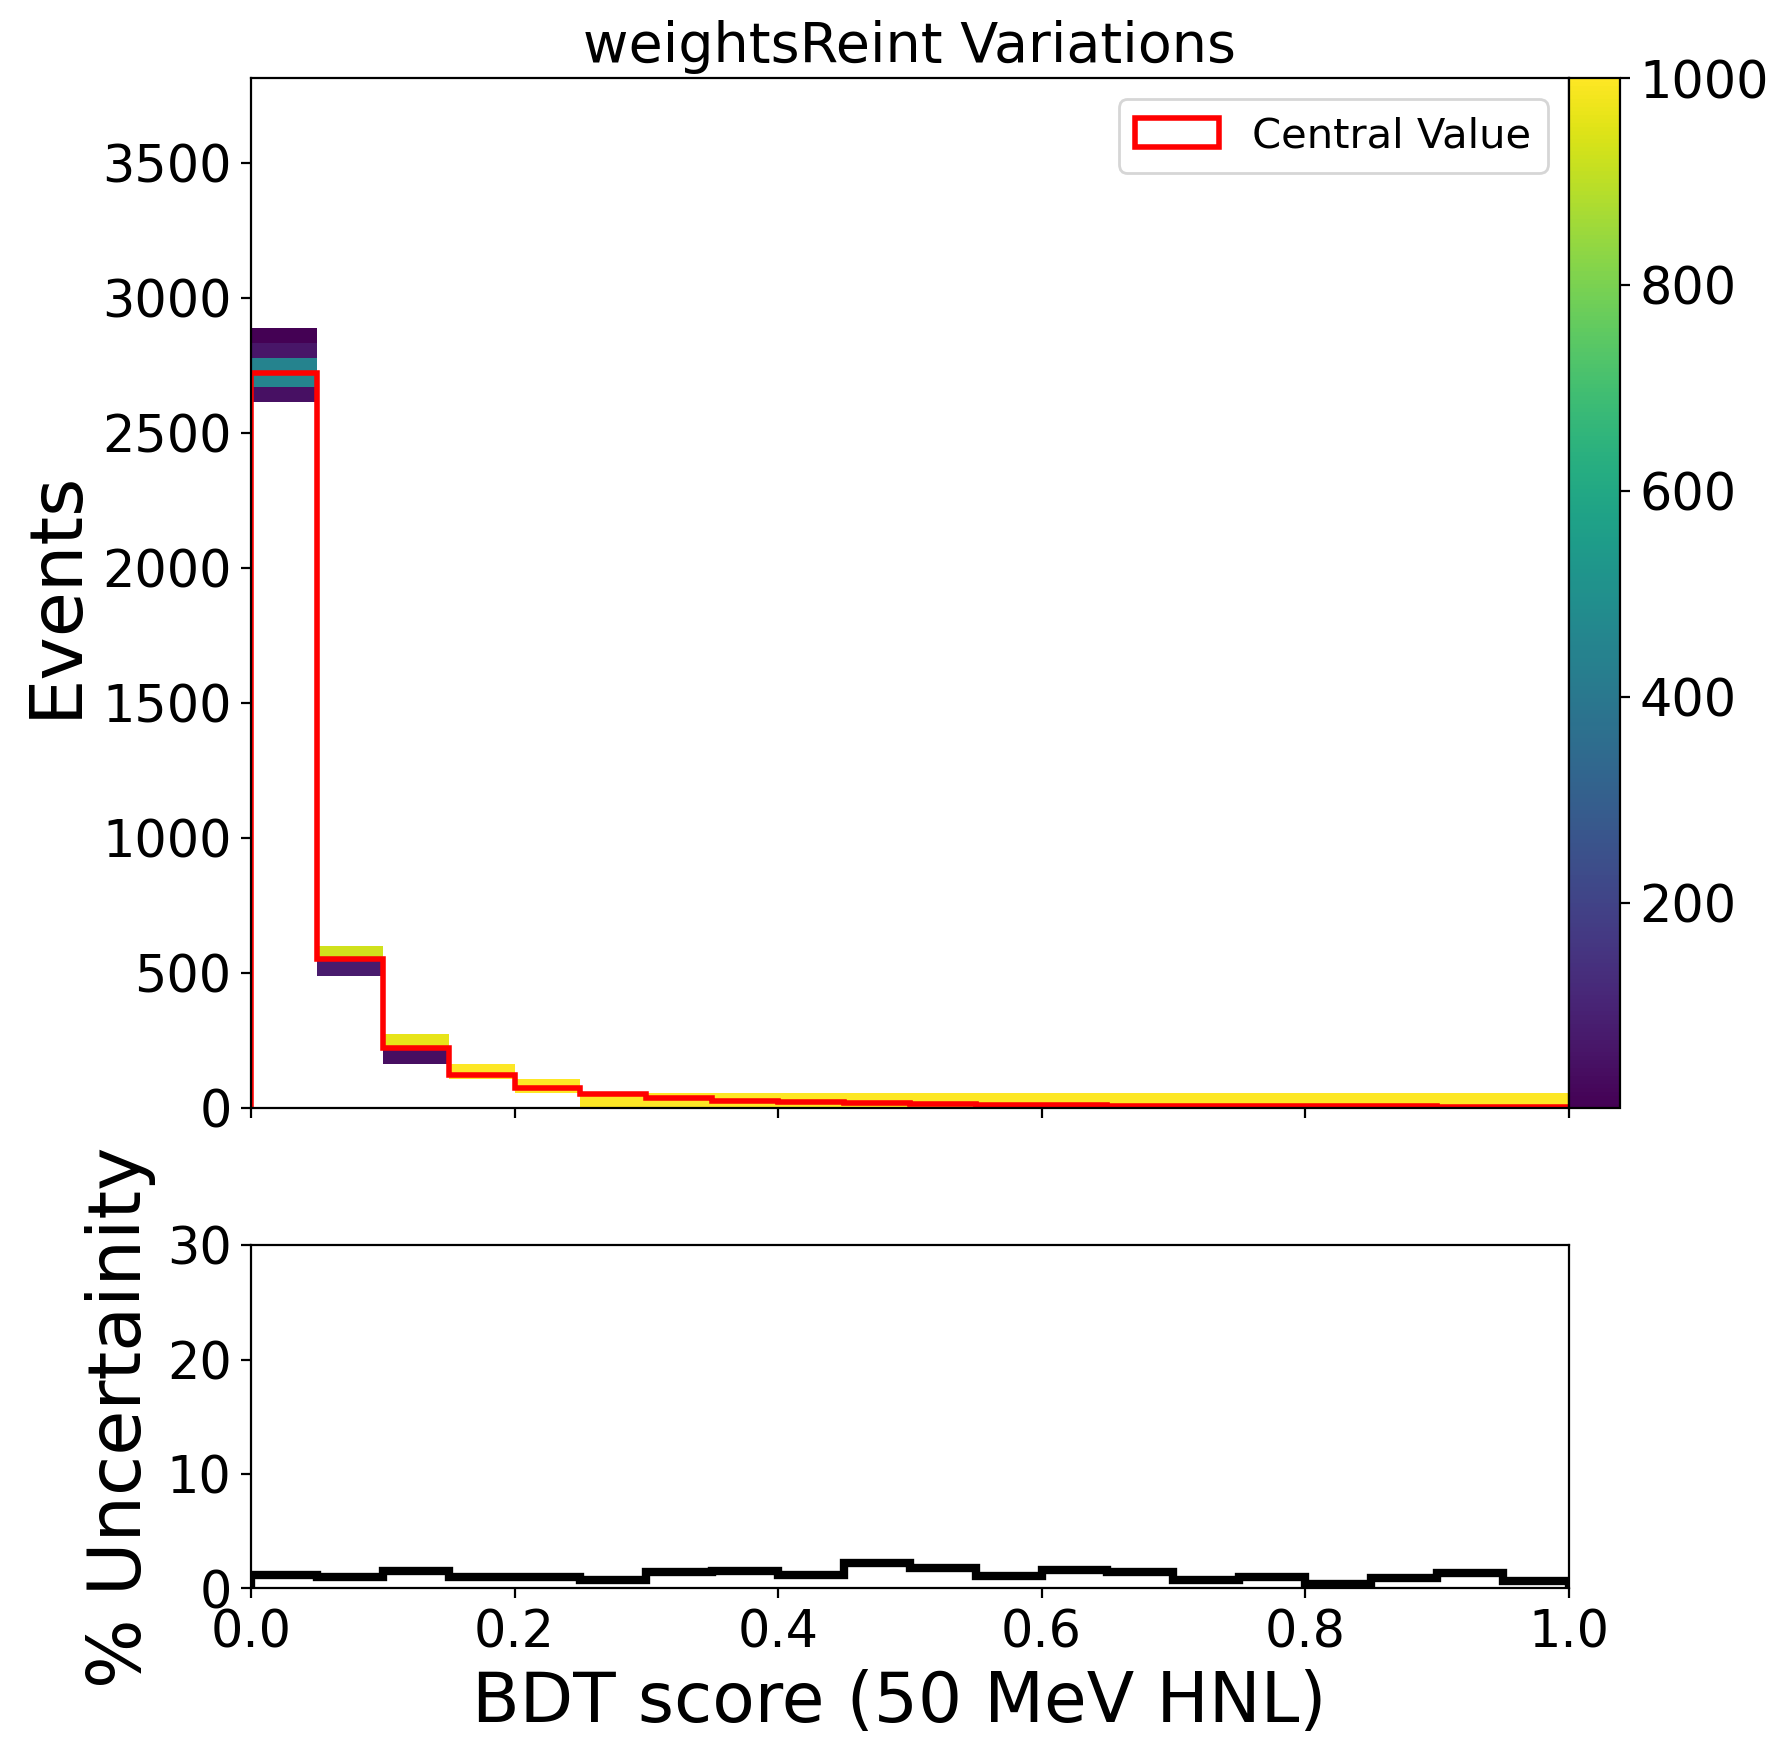

In [10]:
Plot_multisim(results_dict, HNL_mass, savefig=False)

## Calculating and saving total uncertainty for each reweighting

In [12]:
ppfx_unc = np.sqrt(np.diag(results_dict["weightsPPFX"][0]))
ppfx_unc_frac = ppfx_unc/results_dict["weightsPPFX"][1]

genie_unc = np.sqrt(np.diag(results_dict["weightsGenie"][0]))
genie_unc_frac = genie_unc/results_dict["weightsGenie"][1]

reint_unc = np.sqrt(np.diag(results_dict["weightsReint"][0]))
reint_unc_frac = reint_unc/results_dict["weightsReint"][1]


<class 'numpy.ndarray'>
20
[3.65344221e+02 7.74311148e+01 3.12059934e+01 1.71676747e+01
 1.05361436e+01 6.98084900e+00 5.09808409e+00 3.90470692e+00
 2.69011661e+00 2.21236582e+00 1.99739474e+00 1.79803574e+00
 9.46927673e-01 1.78440957e+00 1.03926861e+00 9.09967391e-01
 7.42585171e-01 8.21667611e-01 5.96072106e-01 3.46421706e-01]
[0.13411523 0.14011318 0.13950881 0.13991326 0.13966808 0.13355948
 0.13767789 0.14535316 0.12804586 0.12811503 0.14216847 0.15423672
 0.09705395 0.1981191  0.18450405 0.15612158 0.12862918 0.13816812
 0.12325691 0.11075981]
<class 'numpy.ndarray'>
20
[366.06060293  75.89910063  29.83632415  16.46109453  10.45370361
   6.71785624   4.72235068   3.6873516    2.6421707    2.54313277
   1.81516946   2.09834595   1.37425665   1.76624342   0.79508815
   0.69565686   0.79646396   0.81981763   0.87136531   0.42817084]
[0.13437821 0.13734097 0.1333856  0.13415477 0.13857525 0.12852783
 0.12753091 0.13726208 0.1257637  0.14726929 0.12919823 0.17999753
 0.14085239 0.19

## Saving reweighting uncertainties as .root files

In [13]:
def SaveToRoot(nbins,xlims,uncertainty,name,fileName='test.root'):
    nBins = nbins
    binLimits = xlims
  ### Save files 
    rFile = ROOT.TFile(f'Uncertainties/{fileName}','RECREATE')
    tData1 = ROOT.TH1F(name,name,nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData1.SetBinContent(i+1,uncertainty[i])
    rFile.Write()
    rFile.Close()
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'Uncertainties/{fileName}','RECREATE')
    for name in hist_samples:
        tData1 = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
        for i in range(nbins): 
            tData1.SetBinContent(i+1,hist_samples[name][i])
        rFile.Write()
    rFile.Close()

In [15]:
reweight_errs = {'ppfx_uncertainty': ppfx_unc, 'Genie_uncertainty':genie_unc, 'Reinteraction_uncertainty':reint_unc}
reweight_errs_frac = {'ppfx_uncertainty_frac': ppfx_unc_frac, 'Genie_uncertainty_frac':genie_unc_frac, 
                      'Reinteraction_uncertainty_frac':reint_unc_frac}

SaveToRoot(20,[0,1.0],ppfx_unc,'ppfx_uncertainty',fileName=f'Test_1_{HNL_mass}MeV.root')

SaveToRoot_new(20,[0,1.0],reweight_errs,fileName=Run+f'_Test_2_{HNL_mass}MeV.root')
SaveToRoot_new(20,[0,1.0],reweight_errs_frac,fileName=Run+f'_Test_2_frac_{HNL_mass}MeV.root')